# PRICE PREDICTION

*Представьте, что вы работаете в компании, которая занимается продажей автомобилей с пробегом. Основная задача компании и ее менеджеров - максимально быстро находить выгодные предложения (проще говоря, купить ниже рынка, а продать дороже рынка).*

*Вам поставлена задача создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам. Если наша модель работает хорошо, то мы сможем быстро выявлять выгодные предложения (когда желаемая цена продавца ниже предсказанной рыночной цены). Это значительно ускорит работу менеджеров и повысит прибыль компании.*


# Библиотеки

In [1]:
import warnings
from hyperopt.fmin import fmin
from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
import hyperopt
import sys
import optuna
import xgboost as xgb
import catboost
from catboost import CatBoostRegressor
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, \
    GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import power_transform
from sklearn.metrics import plot_precision_recall_curve, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import numpy as np

import glob
import requests
from random import random, choice
from bs4 import BeautifulSoup
from threading import Thread
import queue
import time
import os
import re
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


warnings.filterwarnings('ignore')
# warnings.simplefilter(action='ignore', category=FutureWarning)

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.6 | packaged by conda-forge | (default, Oct  7 2020, 19:08:05) 
Numpy        : 1.19.4


# Базовые переменные

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt
# Постоянный сегодняшний день
date_today = pd.to_datetime('2021-01-14')
# Создадим дата фрейм для обработанных данных
# df_tmp = pd.DataFrame()
#VERSION = 12
VAL_SIZE = 0.2

# Предобработка

In [3]:
def df_info(data):
    '''
    Cмотрим на данные
    '''
    param = pd.DataFrame({
        'dtypes': data.dtypes.values,
        'nunique': data.nunique().values,
        'isna': data.isna().sum().values,
        'loc[0]': data.loc[0].values,
    },
        index=data.loc[4].index)
    return param


def categorical_info(column_name, data, rotate=90, x_shift_mult=0, percentage=True):
    """
    Рисует распределение категориальных признаков и отображает их процентное содержание
    """

    ax = sns.countplot(x=column_name,
                       data=data,
                       order=data[column_name].value_counts().index, orient="h")
    if percentage:
        total = len(data[column_name])
        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height()/total)
            x = p.get_x() + x_shift_mult*p.get_width()
            y = p.get_y() + p.get_height()+8
            ax.annotate(percentage, (x, y))
    plt.xticks(rotation=rotate)


def numeric_info(data, bins=10):
    """
    Печатает описательные статистики числового признака, а также рисует его распределение
    """

    print(data.describe()[["min", "max", "25%", "50%", "75%", "std"]])
    sns.distplot(data, bins=bins)


"""
Визуализация для EDA
"""


def horizontal_barplots(column, data, title_name):
    plt.rcParams['figure.figsize'] = 10, 10
    ax = sns.barplot(x=0, y=column, hue='train', data=data)
    show_values_on_bars(ax, 'h', 10)
    plt.title(title_name)
    plt.show()


def vertical_boxplots(col_x, col_y, data, title_name, fsize=[16, 8]):
    plt.rcParams['figure.figsize'] = fsize[0], fsize[1]
    plt.ticklabel_format(style='plain', axis='x')
    ax = sns.boxplot(data=data, orient="v", y=col_x, x=col_y)
    plt.title(title_name)
    plt.show()


def horizontal_boxplots(col_x, col_y, data, title_name):
    plt.rcParams['figure.figsize'] = 16, 8
    plt.ticklabel_format(style='plain', axis='x')
    ax = sns.boxplot(data=data, orient="h", x=col_x, y=col_y)
    plt.title(title_name)
    plt.show()


def horizontal_heatmap(col_x, col_y, data, title_name):
    maps = df.groupby([col_x, col_y])[col_x].count().unstack().T
    plt.rcParams['figure.figsize'] = 18, 4
    sns.heatmap(maps)
    plt.title(title_name)
    plt.show()


def vertical_boxplots(col_x, col_y, data, title_name, fsize=[16, 8]):
    plt.rcParams['figure.figsize'] = fsize[0], fsize[1]
    plt.ticklabel_format(style='plain', axis='x')
    ax = sns.boxplot(data=data, orient="v", y=col_x, x=col_y)
    plt.title(title_name)
    plt.show()


def histplot_train(col, df, title_name, bins=50):
    plt.rcParams['figure.figsize'] = 12, 6
    plt.ticklabel_format(style='plain', axis='x')
    sns.histplot(x=col, hue='train', data=df, kde=True, bins=bins)
    plt.title(title_name)
    plt.show()


def bars_counts(col, df, title_name):
    models = df[col].value_counts().reset_index()[0:25]
    models.columns = [col, 'quantity']
    plt.rcParams['figure.figsize'] = 12, 10
    ax = sns.barplot(x='quantity', y=col, data=models)
    show_values_on_bars(ax, 'h', 10)
    plt.title(title_name)
    plt.show()


def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center")
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()/2
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left", va='center')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


def outliers(column):
    ''' 
    определяем квартили и границы выбросов для признаков 
    '''
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    up = perc75 + 1.5*IQR
    print(column)
    k = 0
    for i in df[column]:
        if i <= low or i >= up:
            k += 1
    if k > 0:
        print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
              "IQR: {}, ".format(IQR), "Границы выбросов: [{}, {}],".format(low, up), 'Количество выбросов - ', k)
    else:
        print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
              "IQR: {}, ".format(IQR), "Границы выбросов: [{}, {}],".format(low, up), 'Выбросов нет')


def model_extract(row):
    """
    Производит поиск по шаблонам в столбце name, 
    выводит значение в столбец model
    """
    model = re.search(model_re, row['name'])
    if model is not None:
        row['model'] = model.group(0)

    model = re.search(model_x, row['name'])
    if model is not None:
        row['model'] = model.group(0)

    model = re.search(model_oth, row['name'])
    if model is not None:
        row['model'] = model.group(0)

    return row


def model_create(row):
    """
    Производит поиск по шаблонам в описании авто, 
    создает значение в столбце model_descr
    """
    model = re.search(model_re, row['descr'])
    if model is not None:
        row['name_descr'] = model.group(0)
    model = re.search(model_x, row['descr'])
    if model is not None:
        row['name_descr'] = model.group(0)
    return row


"""
метрика оценки качества
"""


def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))


def print_learn_report(start, y_test, y_pred):
    print(f'\nВремя выполнения: {time.time() - start:.1f}')
    print(f'\nТочность по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}')

# Загрузка данных

In [4]:
sample_submission = pd.read_csv('sample_submission.csv')


def load_data():
    df_train = pd.read_csv('df_train')
    df_test = pd.read_csv('test.csv.zip')
    print('Размерность тренировочного датасета: ', df_train.shape)
    print('Размерность тестового датасета: ', df_test.shape)
    return df_train, df_test

In [5]:
# df_train.to_csv('df_train', index=False)
# df_test.to_csv('df_test', index=False)

# Объеденяем датафрейм и помечаем

In [6]:
df_train, df_test = load_data()

Размерность тренировочного датасета:  (57708, 35)
Размерность тестового датасета:  (34686, 32)


In [7]:
def combine_data():
    '''
    Обьединяем датафрейм
    '''
    df_train['train'] = 1  # помечаем где у нас трейн
    df_test['train'] = 0  # помечаем где у нас тест
    df = pd.concat([df_train, df_test])
    return df


df = combine_data()
df.head(2)

,bodyType,brand,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,...,auto_class,price_segment,seller_type,section,url_saleid,color,train,car_url,complectation_dict,Владение
0,хэтчбек 5 дв.,MERCEDES,"Наличие гарантии или сервисных контрактов, Ори...",1332,150,"{'alloy-wheel-disks': True, 'glonass': True, '...",бензин,//avatars.mds.yandex.net/get-autoru-vos/217386...,10939,2018,...,C,PREMIUM,COMMERCIAL,NaN,NaN,белый,1,NaN,NaN,NaN
1,хэтчбек 5 дв.,MERCEDES,Официальный дилер Mercedes-Benz \nООО «РОЛЬФ» ...,1595,122,"{'cruise-control': True, 'asr': True, 'airbag-...",бензин,//avatars.mds.yandex.net/get-autoru-vos/158389...,56671,2012,...,C,PREMIUM,COMMERCIAL,NaN,NaN,белый,1,NaN,NaN,NaN


# Пропуски и дубликаты

bodyType                    0
brand                       0
description              1819
engineDisplacement          0
enginePower                 0
equipment_dict          23196
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы               12799
ПТС                       334
Привод                      0
Руль                        0
Состояние                 880
Таможня                     0
price                   34686
auto_class              34998
price_segment           34686
seller_type             34686
section                 38355
url_saleid

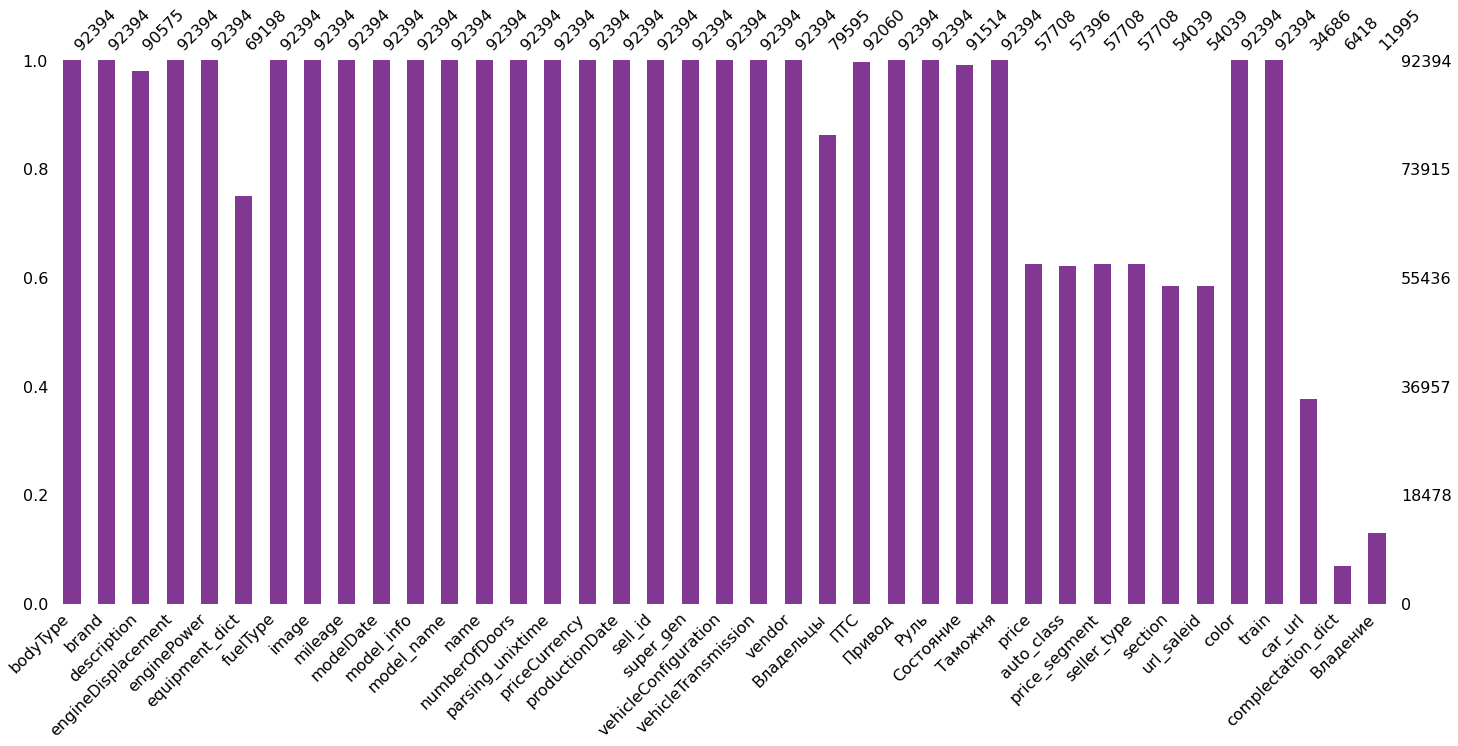

In [8]:
print(df.isna().sum(), msno.bar(df, color=(0.505, 0.221, 0.578), ))

In [9]:
# изменим имена всех столбцов
df.columns = df.columns.str.lower()


def re_name(df):
    df.columns = ['bodytype', 'brand', 'descr', 'engine_displ',
                  'enginepower', 'equipment_dict', 'fuel', 'image',
                  'miles', 'model_year', 'model_info', 'model_name',
                  'name', 'doors', 'parsing_unixtime', 'pricecurrency',
                  'prod_year', 'sell_id', 'super_gen', 'veh_conf',
                  'transm',  'vendor', 'owners', 'pts', 'drive', 'wheel',
                  'rep_state', 'customs', 'price', 'auto_class',
                  'price_segment', 'seller_type', 'section',
                  'url_saleid', 'color',
                  'train', 'car_url',  'options', 'own']
    return df


re_name(df)


# engine_displ

# Обрабатываем тренировочные значения,приводим к одному формату
df_train.engineDisplacement = df_train.engineDisplacement.apply(
    lambda x: round(x / 1000, 1))

# Обрабатываем тестовые значения,приводим к числовому форматы и заменяем значения undefined LTR на 0
df_test.engineDisplacement = (df_test.engineDisplacement
                              .str.replace(' LTR', '0')
                              .str.strip()).astype(float)

# Обьединяем
df = combine_data()
re_name(df)
df.columns = df.columns.str.lower()


# body_type
def map_body_type(df):
    df = df.copy()
    '''Обработка типа кузова'''
    df.loc[df.bodytype.str.contains('седан'), 'body_type'] = 'sedan'
    df.loc[df.bodytype.str.contains('внедорожник'), 'body_type'] = 'off-roader'
    df.loc[df.bodytype.str.contains('лифтбек'), 'body_type'] = 'liftback'
    df.loc[df.bodytype.str.contains(
        'универсал'), 'body_type'] = 'station wagon'
    df.loc[df.bodytype.str.contains('минивэн'), 'body_type'] = 'minivan'
    df.loc[df.bodytype.str.contains('купе'), 'body_type'] = 'compartment'
    df.loc[df.bodytype.str.contains('компактвэн'), 'body_type'] = 'compact MRV'
    df.loc[df.bodytype.str.contains('пикап'), 'body_type'] = 'pickup truck'
    df.loc[df.bodytype.str.contains('родстер'), 'body_type'] = 'roadster'
    df.loc[df.bodytype.str.contains('фургон'), 'body_type'] = 'the van'
    df.loc[df.bodytype.str.contains('кабриолет'), 'body_type'] = 'cabriolet'
    df.loc[df.bodytype.str.contains('микровэн'), 'body_type'] = 'microven'
    df.loc[df.bodytype.str.contains('лимузин'), 'body_type'] = 'limousine'
    df.loc[df.bodytype.str.contains('тарга'), 'body_type'] = 'targa'
    df.loc[df.bodytype.str.contains('фастбек'), 'body_type'] = 'fastback'
    df.loc[df.bodytype.str.contains('хэтчбек'), 'body_type'] = 'hechback'

    return df


df = map_body_type(df)
# Проверка
# tmp = map_body_type(df)
# tmp.loc[tmp.body_type.isna(), 'bodytype'].value_counts()


# owners
df['owners'] = (df['owners']
                .apply(lambda x: str(x).split()[0])
                .replace('nan', 0)
                .astype(float)
                .astype(int))


# pts
df.pts.isna().sum()
df['pts'].fillna('Оригинал', inplace=True)


# enginepower
df.enginepower = df.enginepower.astype(str).str.replace('N12', '').astype(int)
df = df[(df['enginepower'] <= 639) & (df['enginepower'] >= 30)]


# descr - описание автомобиля от продавца
df.descr.isna().sum()
# Пропусков 141, пока заменим их на "Not know"
df.descr = df.descr.fillna('Not know')


def map_descr(df):
    df = df.copy()
    # Создание столбца дилеры
    df.loc[df.descr.str.lower().str.contains('рольф'), 'dealer'] = 'rolf'
    df.loc[df.descr.str.lower().str.contains(
        'организация продаж автомобилей с пробегом'), 'dealer'] = 'rolf'
    df.loc[df.descr.str.lower().str.contains(
        'бесплатная техническая и юридическая'), 'dealer'] = 'rolf'
    df.loc[df.descr.str.lower().str.contains(
        'ключавто'), 'dealer'] = 'kluchauto'
    df.loc[df.descr.str.lower().str.contains('автодом'), 'dealer'] = 'autodom'
    df.loc[df.descr.str.lower().str.contains('autodom'), 'dealer'] = 'autodom'
    df.loc[df.descr.str.contains('ABTODOM'), 'dealer'] = 'autodom'
    df.loc[df.descr.str.lower().str.contains(
        'по более 40 параметрам'), 'dealer'] = 'auto_expert'
    df.loc[df.descr.str.lower().str.contains(
        'по более 48 параметрам'), 'dealer'] = 'auto_expert'
    df.loc[df.descr.str.lower().str.contains(
        'услугой трейд-ин'), 'dealer'] = 'rolf'
    df.loc[df.descr.str.contains(
        'АВТОМОБИЛЬ ПОДГОТОВЛЕН К ПРОДАЖЕ'), 'dealer'] = 'autoprice'
    df.loc[df.descr.str.contains('Евро Кар'), 'dealer'] = 'eurocar'
    df.loc[df.descr.str.lower().str.contains(
        'выгода 120 000 рублей'), 'dealer'] = 'pulsar'
    df.loc[df.descr.str.contains('АВТОРУСЬ'), 'dealer'] = 'autorus'
    df.loc[df.descr.str.contains('Сокол Моторс'), 'dealer'] = 'sokol_motors'
    df.loc[df.descr.str.lower().str.contains(
        'кан авто'), 'dealer'] = 'kan_auto'
    df.loc[df.descr.str.lower().str.contains(
        'Not know'), 'dealer'] = 'not know'
    df.loc[df.descr.str.contains('БЦР'), 'dealer'] = 'bcr_motors'
    df.loc[df.dealer.isna(), 'dealer'] = 'owner'

    # торг
    df.loc[df.descr.str.lower().str.contains('торг'), 'discount'] = 'yes'
    df.loc[df.descr.str.lower().str.contains('торга'), 'discount'] = 'no'
    df.loc[df.discount.isna(), 'discount'] = 'no'

    return df


df = map_descr(df)

# price


def target_price(df):
    plt.rcParams['figure.figsize'] = 12, 6
    plt.ticklabel_format(style='plain', axis='x')
    sns.histplot(x='price', data=df, kde=True, bins=100)
    plt.title('Цена на автомобили BMW')
    plt.axvline(1600000, 0, 3000, color='red')
    plt.axvline(5300000, 0, 3000, color='red')
    plt.axvline(9300000, 0, 3000, color='black')
    plt.show()
    pd.options.display.float_format = '{:.2f}'.format
    df['price'].describe()
    return df


# enginepower
df.enginepower = df.enginepower.astype(str).str.replace('N12', '').astype(int)
df = df[(df['enginepower'] <= 639) & (df['enginepower'] >= 30)]

# EDA - Разведывательный анализ данных

## price - цена (Целевая)

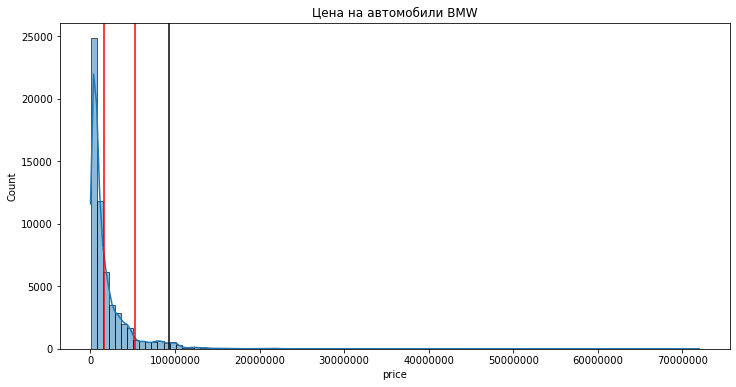

,bodytype,brand,descr,engine_displ,enginepower,equipment_dict,fuel,image,miles,model_year,...,section,url_saleid,color,train,car_url,options,own,body_type,dealer,discount
0,хэтчбек 5 дв.,MERCEDES,"Наличие гарантии или сервисных контрактов, Ори...",1.30,150,"{'alloy-wheel-disks': True, 'glonass': True, '...",бензин,//avatars.mds.yandex.net/get-autoru-vos/217386...,10939,2018,...,NaN,NaN,белый,1,NaN,NaN,NaN,hechback,owner,no
1,хэтчбек 5 дв.,MERCEDES,Официальный дилер Mercedes-Benz \nООО «РОЛЬФ» ...,1.60,122,"{'cruise-control': True, 'asr': True, 'airbag-...",бензин,//avatars.mds.yandex.net/get-autoru-vos/158389...,56671,2012,...,NaN,NaN,белый,1,NaN,NaN,NaN,hechback,rolf,no
2,хэтчбек 5 дв.,MERCEDES,Not know,1.60,122,"{'cruise-control': True, 'airbag-rear-side': T...",бензин,//avatars.mds.yandex.net/get-autoru-vos/212741...,95000,2012,...,NaN,NaN,синий,1,NaN,NaN,NaN,hechback,owner,no
3,хэтчбек 5 дв.,MERCEDES,Not know,1.60,122,"{'tinted-glass': True, 'start-stop-function': ...",бензин,//avatars.mds.yandex.net/get-autoru-vos/213411...,97000,2012,...,NaN,NaN,черный,1,NaN,NaN,NaN,hechback,owner,no
4,хэтчбек 5 дв.,MERCEDES,Вашему вниманию представляется автомобиль Merc...,1.60,122,"{'paint-metallic': True, 'eco-leather': True, ...",бензин,//avatars.mds.yandex.net/get-autoru-vos/216637...,85380,2012,...,NaN,NaN,серый,1,NaN,NaN,NaN,hechback,owner,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34681,седан,BMW,Продается BMW 316i в отличном состоянии. Прода...,1.60,136,"{""cruise-control"":true,""asr"":true,""tinted-glas...",бензин,https://autoru.naydex.net/nwI1K7152/b604fdsYg7...,115000,2011,...,NaN,NaN,коричневый,0,https://auto.ru/cars/used/sale/bmw/3er/1101369...,NaN,2 года и 1 месяц,sedan,owner,no
34682,седан,BMW,Продаётся отличный автомобиль.,2.00,190,NaN,дизель,https://autoru.naydex.net/nwI1K7152/b604fdsYg7...,98000,2016,...,NaN,NaN,чёрный,0,https://auto.ru/cars/used/sale/bmw/5er/1101369...,NaN,NaN,sedan,owner,no
34683,седан,BMW,Хорошее состояние,2.50,170,NaN,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,360000,1995,...,NaN,NaN,серый,0,https://auto.ru/cars/used/sale/bmw/5er/1101364...,NaN,NaN,sedan,owner,no
34684,внедорожник 5 дв.,BMW,Автомобиль в идеальном состоянии . Куплен новы...,2.00,184,"{""engine-proof"":true,""esp"":true,""start-stop-fu...",дизель,https://autoru.naydex.net/nwI1K7152/b604fdsYg7...,90500,2012,...,NaN,NaN,коричневый,0,https://auto.ru/cars/used/sale/bmw/x1/11013625...,"{""id"":""6336008"",""name"":""xDrive20d Локальная сб...",NaN,off-roader,owner,yes


In [10]:
target_price(df)

* Цена имеет  распределение с длинным правом концом

## brand 

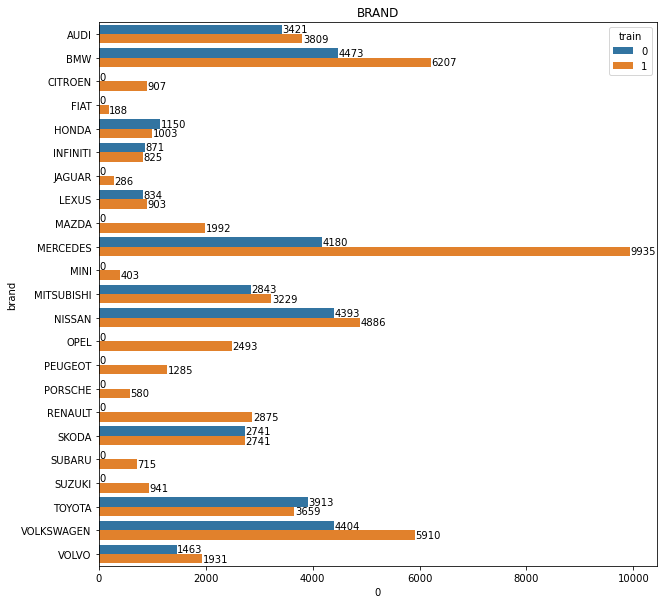

In [11]:
# группируем данные, преобразоваваем, чтобы не было потерь в NAN
avto_brand = df.groupby(['brand', 'train'], dropna=False)[
    'brand'].count().unstack().fillna(0).unstack().reset_index()
horizontal_barplots('brand', avto_brand, 'BRAND')

* Самые популярные машины MERCEDES, BMW, VOLKSWAGEN
* Tакже в тестовых данные отсутвуют редкие машины, удалим их

In [12]:
# удаляем
df = df.loc[~df.brand.isin(['FIAT', 'JAGUAR', 'MINI', 'PORSCHE', 'SUBARU', 'CITROEN',
                            'SUZUKI', 'PEUGEOT', 'MAZDA', 'OPEL', 'RENAULT'])]

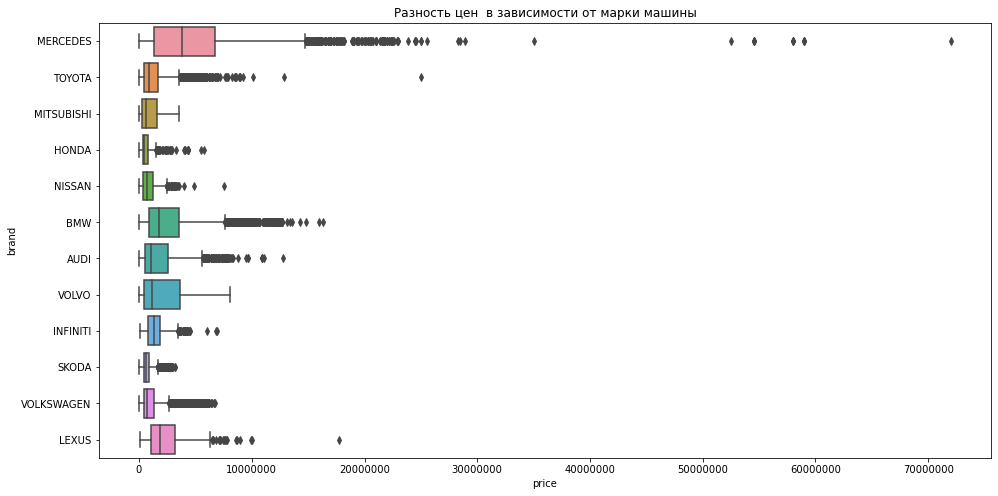

In [13]:
horizontal_boxplots('price', 'brand', df,
                    'Разность цен  в зависимости от марки машины')

## body_type - тип кузова 

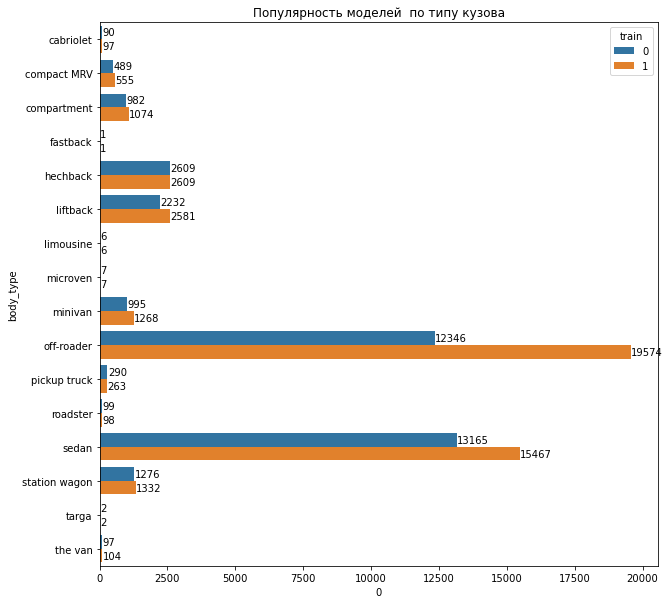

In [14]:
# группируем данные, преобразоваваем, чтобы не было потерь в NAN
bmw_group = df.groupby(['body_type', 'train'], dropna=False)[
    'body_type'].count().unstack().fillna(0).unstack().reset_index()
horizontal_barplots('body_type', bmw_group,
                    'Популярность моделей  по типу кузова')

* Самые популярные типы кузовов - 'off-roader' и 'sedan'

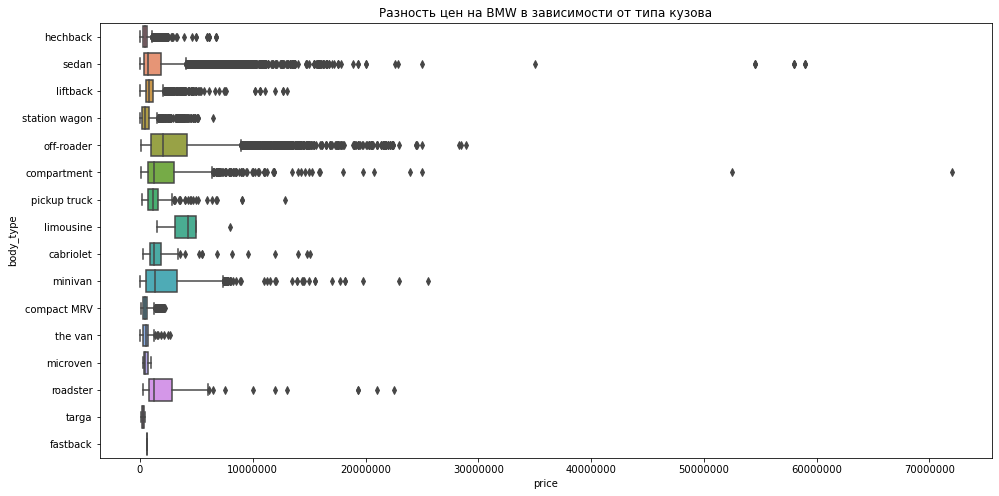

In [15]:
horizontal_boxplots('price', 'body_type', df,
                    'Разность цен на BMW в зависимости от типа кузова')

* Между ценами на тип кузова очень большие различия, как по цене, так и по разбросу. Можно было бы считать если бы цена на автомобиль на зависела от других факторов, как пробег и год выпуска.


## color - цвет кузова

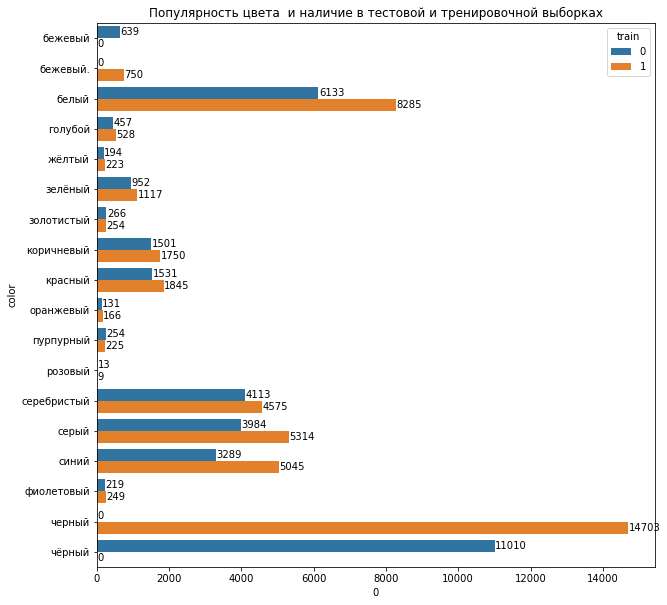

In [16]:
# группируем данные, преобразоваваем, чтобы не было потерь в NAN
bmw_color = df.groupby(['color', 'train'], dropna=False)[
    'color'].count().unstack().fillna(0).unstack().reset_index()
horizontal_barplots('color', bmw_color,
                    'Популярность цвета  и наличие в тестовой и тренировочной выборках')

* Владельцы предпоитают черный автомобиль

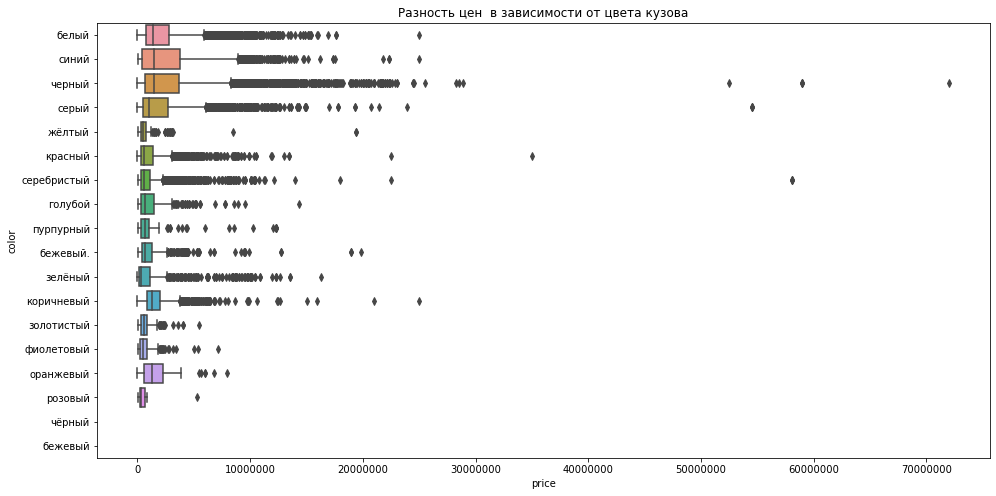

In [17]:
horizontal_boxplots('price', 'color', df,
                    'Разность цен  в зависимости от цвета кузова')

* Чем более распростанен цвет, тем там больше "выбросов" на боксплотах, но это опять связано с популярностью марки, и годом выпуска.

## drive - тип привода

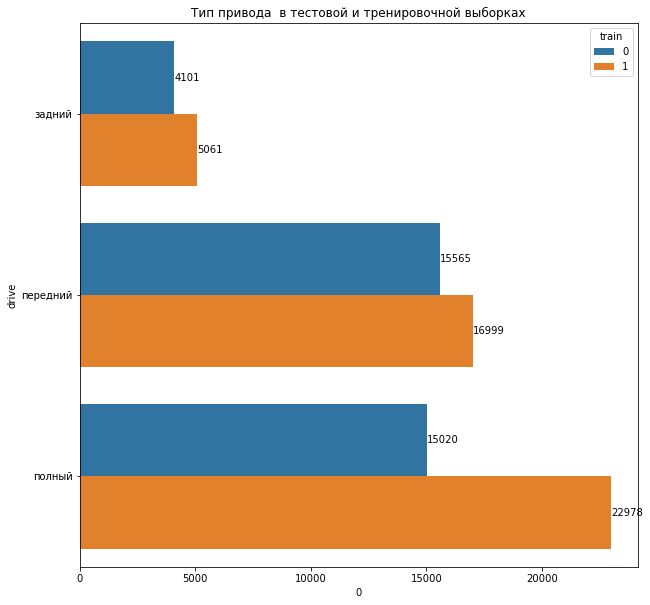

полный      37998
передний    32564
задний       9162
Name: drive, dtype: int64

In [18]:
avto_drive = df.groupby(['drive', 'train'], dropna=False)[
    'drive'].count().unstack().fillna(0).unstack().reset_index()
horizontal_barplots('drive', avto_drive,
                    'Тип привода  в тестовой и тренировочной выборках')
df.drive.value_counts()

* В основном полный и передний привод

## engine_displ - объем двигателя

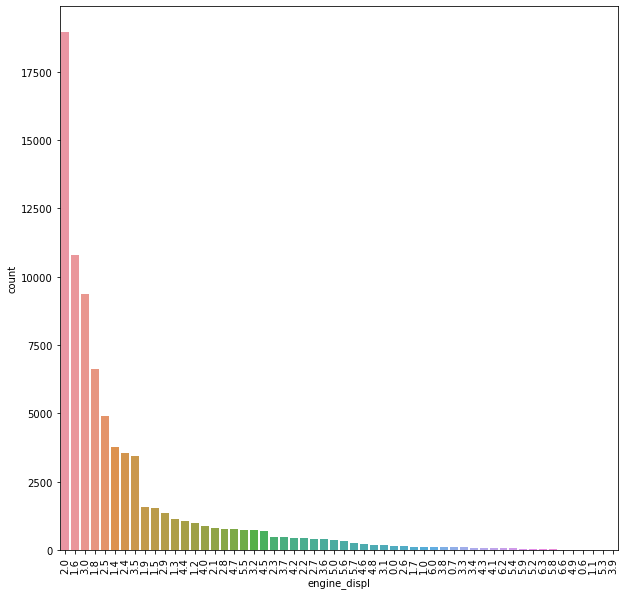

In [19]:
categorical_info("engine_displ", df, percentage=False)

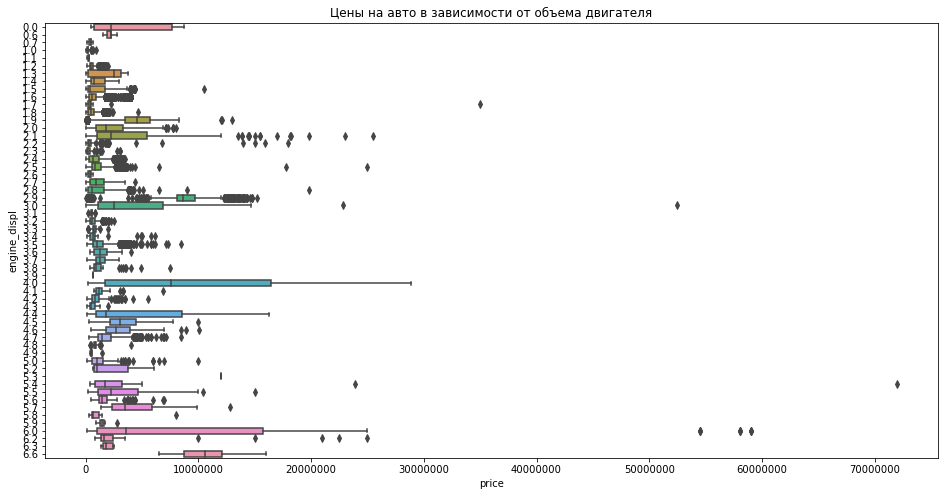

In [20]:
horizontal_boxplots('price', 'engine_displ', df,
                    'Цены на авто в зависимости от объема двигателя')

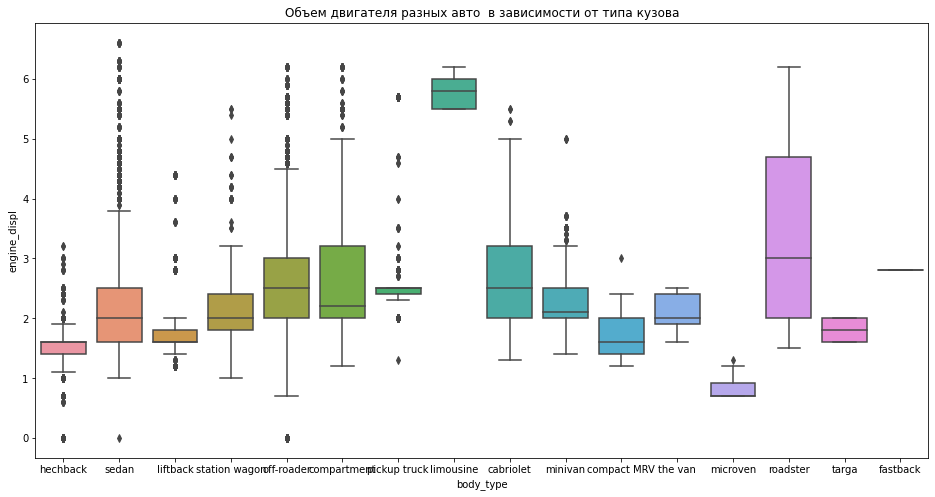

In [21]:
vertical_boxplots('engine_displ', 'body_type', df,
                  'Объем двигателя разных авто  в зависимости от типа кузова')

* Почти все от 2х литров и больше
* Цена на авто зависит от объема двигателя, но здесь нет зависимости, цена больше привязана к модели авто, а также к году выпуска

## fuel - тип топлива

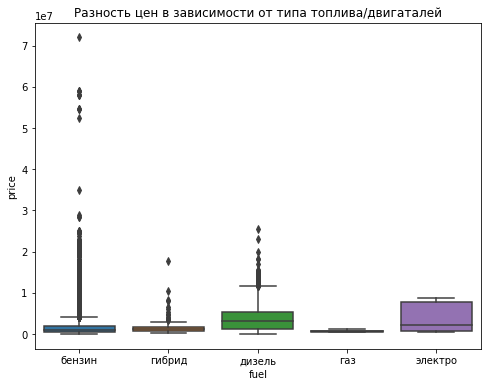

бензин     63696
дизель     15424
гибрид       447
электро      138
газ           19
Name: fuel, dtype: int64

In [22]:
vertical_boxplots('price', 'fuel', df,
                  'Разность цен в зависимости от типа топлива/двигаталей', fsize=[8, 6])
df['fuel'].value_counts()

* Авто с бензиновыми двигателями наиболее дешевые, а электродвигатели и гибриды более дорогие. Тем не менее самые дорогие авто тоже с бензиновым двигателем

## model_year - год запуска модели в производство (поколение)

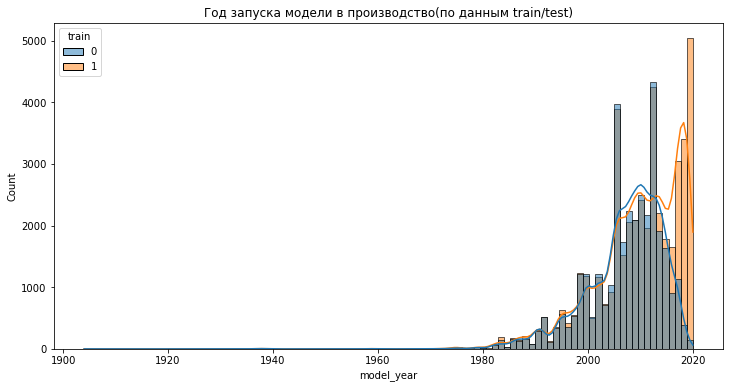

In [23]:
histplot_train('model_year', df,
               'Год запуска модели в производство(по данным train/test)', bins=100)

* Можно сразу сделать вывод: в датасете есть автомобили, которые можно считать раритетными, и они скорее всего по 1-2 шт. Но есть ли они в тестовых данных.

In [24]:
df[df.train == 0].model_year.min()

1904

* Eсть, не будем трогать

## prod_year (год производства автомобиля)

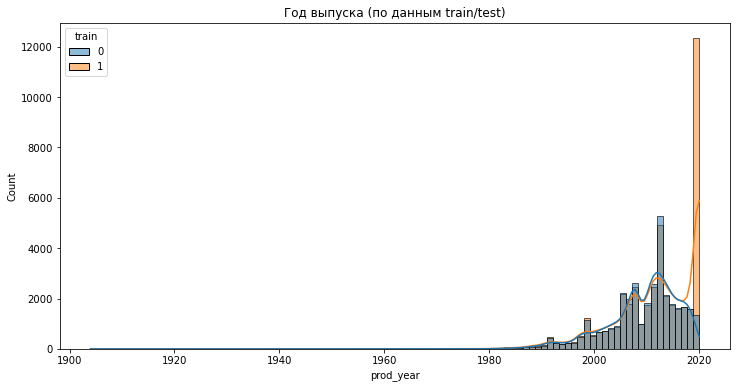

In [25]:
histplot_train('prod_year', df, 'Год выпуска (по данным train/test)', bins=100)

* В моих данных количество свежих автомобилей значительно больше
* Большой разброс
* Также стоит учесть, что при покупке больше интересует возраст, поэтому преобразуем этот признак а car_age
* Очень интересно в train/test есть машина 1904 года

In [26]:
df['car_age'] = (2020 - df['prod_year']).astype(int)

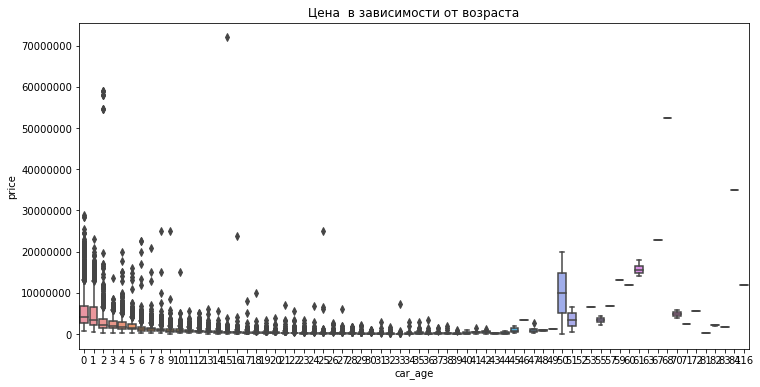

In [27]:
plt.ticklabel_format(style='plain', axis='y')
vertical_boxplots('price', 'car_age', df,
                  'Цена  в зависимости от возраста', fsize=[12, 6])

* После 14 лет средняя цена на авто почти не меняется. "Выбросы" принадлежат спорткарам, броневикам и пр. особенным моделям.

## owners - количество собственников

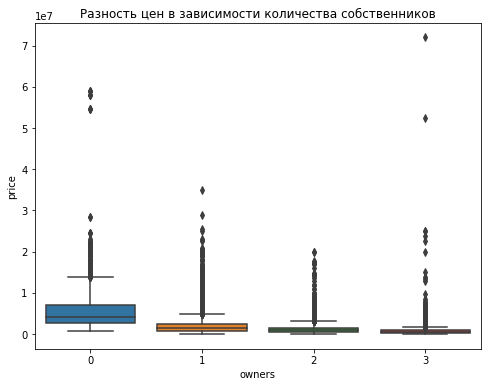

In [28]:
vertical_boxplots('price', 'owners', df,
                  'Разность цен в зависимости количества собственников', fsize=[8, 6])

* Каждый знает, что лучше покупать новое авто или  только у первого хозяина, без лизингов и огромного числа владельцев. Боксплоты также это подтверждают. 

## transm - тип трансмиссии

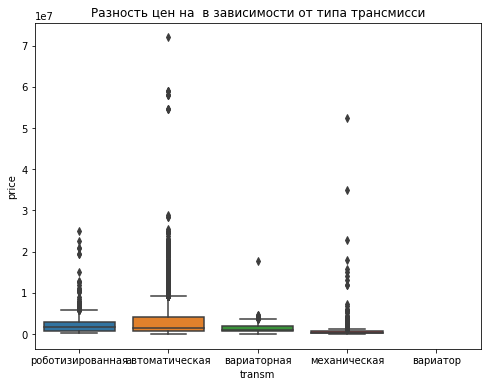

автоматическая     57.62
механическая       19.07
роботизированная   12.07
вариаторная         6.22
вариатор            5.02
Name: transm, dtype: float64

In [29]:
vertical_boxplots('price', 'transm', df,
                  'Разность цен на  в зависимости от типа трансмисси', fsize=[8, 6])
df.transm.value_counts(normalize=True) * 100

* Автоматическая трансмиссия занимает 58% от общего числа автомобилей в исследовании. Ручная коробка на автомобилях более ранних серий. Робот встречается на автомобилях спортивных серий, что отражается на цене.

## pts - ПТС( оригинал или дубликат)

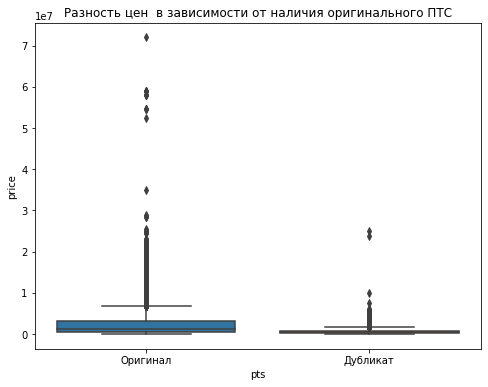

In [30]:
vertical_boxplots('price', 'pts', df,
                  'Разность цен  в зависимости от наличия оригинального ПТС', fsize=[8, 6])

* В целом авто с оригинальными ПТС стоят дороже, дорогие авто (>3 млн) с дубликатом не продаются.

## miles - пробег в километрах

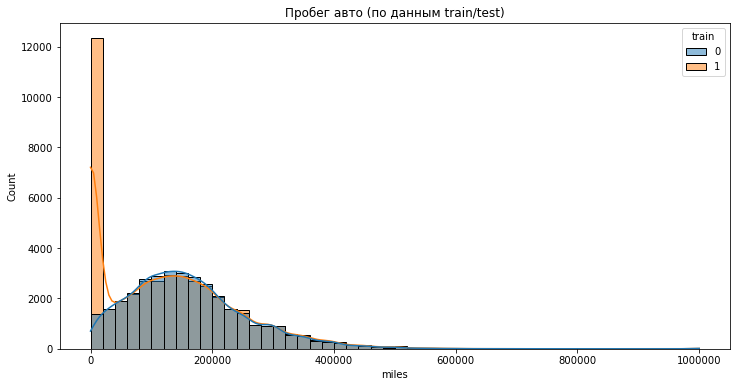

In [31]:
histplot_train('miles', df, 'Пробег авто (по данным train/test)')

* На графике виден автомобиль с 1 млн км !!!!. Проверим данные на выбросы

In [32]:
print(outliers('miles'))

miles
25-й перцентиль: 55500.0, 75-й перцентиль: 202000.0, IQR: 146500.0,  Границы выбросов: [-164250.0, 421750.0], Количество выбросов -  1181
None


* Опять более новые данные дают о себе знать
* Пробег автомобилей в датасете варьируется от 1 до 1000000 км. 
* Распределение признака ассиметрично, с правым "хвостом"
* В тестовых и тренировочных данных есть машины с 1мил. пробегом,поэтому трогать их не будем
* Необходимо нормализовать признак

## enginePower (мощность двигателя)

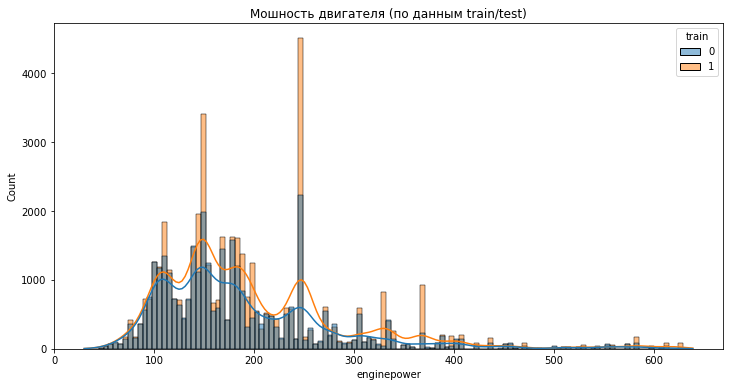

In [33]:
histplot_train('enginepower', df,
               'Мошность двигателя (по данным train/test)', bins=125)

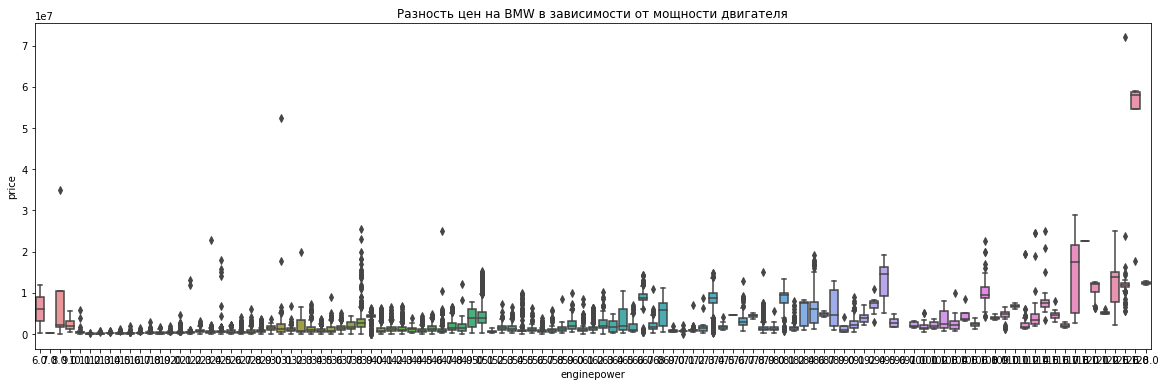

In [34]:
df.enginepower = round(df.enginepower / 5)
vertical_boxplots('price', 'enginepower', df,
                  'Разность цен  в зависимости от мощности двигателя', fsize=[20, 6])

* Интересный момент, что после мощности 250 цена падает, по сравнению с 225. Есть такая особенность, в продажах авто, как налог на л.с. и свыше 250 л.с. и и так же привязан к средней стоимости и возрасту авто. На стоимость этот фактор влияет, т.е. в объявлениях иногда указана сумма налога.

##  dealer - продавец: салон или частное лицо

In [35]:
df.dealer.value_counts()

owner          71790
rolf            6045
autodom         1014
autorus          366
auto_expert      258
kluchauto        200
pulsar            45
kan_auto           6
Name: dealer, dtype: int64

* Кроме основных больших дилеров (РОЛЬФ и АВТОДОМ), доля основных мала. заменим их просто на other_dealers

In [36]:
dealers = ['owner', 'rolf', 'autodom']
df.loc[~df.dealer.isin(dealers), 'dealer'] = 'other_dealers'

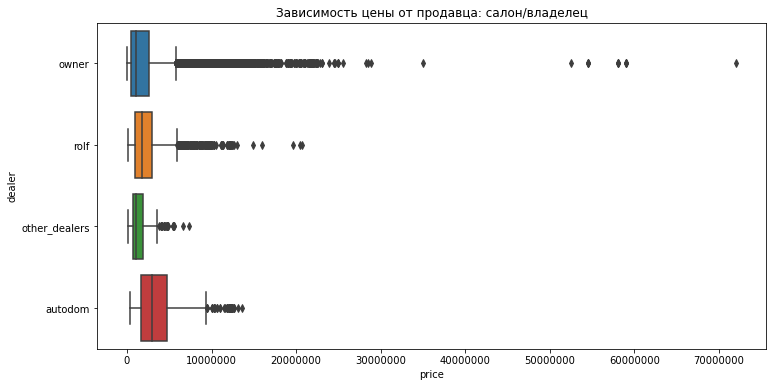

In [37]:
plt.rcParams['figure.figsize'] = 12, 6
plt.ticklabel_format(style='plain', axis='x')
horizontal_boxplots('price', 'dealer', df,
                    'Зависимость цены от продавца: салон/владелец')

* Интересно. Частные лица, владельцы авто(owner) продают гораздо дешевле, чем салоны. У больших автосалонов (РОЛЬФ, АВТОДОМ) цены могут быть еще выше чем у других салонов, но это объясняет более дорогими авто. Остальные мелкие дилеры занимают промежуточное место.

## discount - торг (да/нет)

In [38]:
df.discount.value_counts()

no     64073
yes    15651
Name: discount, dtype: int64

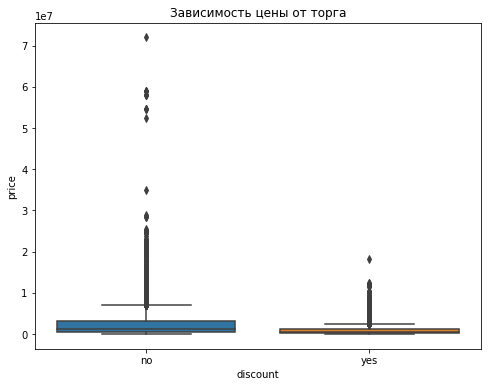

In [39]:
vertical_boxplots('price', 'discount', df,
                  'Зависимость цены от торга', fsize=[8, 6])

* B целом цены на авто, где и так предусмотен торг - ниже, чем не те, где нет. Хотя максимальная цена может быть около 8 млн, а максимальная 12 млн

## model_name - модель машины

In [40]:
df_test.model_name

0        OCTAVIA
1        OCTAVIA
2         SUPERB
3        OCTAVIA
4        OCTAVIA
          ...   
34681        3ER
34682        5ER
34683        5ER
34684         X1
34685         X5
Name: model_name, Length: 34686, dtype: object

In [41]:
df.groupby(['train', 'model_name'])['model_name'].size().unstack()

model_name,02,100,100NX,100_SERIES,120,140,190_SL,1ER,200,200SX,...,X_TRAIL,YARIS,YARIS_VERSO,YETI,Z,Z1,Z3,Z3M,Z4,ZEST
train,,,,,,,,,,,,,,,,,,,,,
0,1.00,109.00,1.00,1.00,2.00,1.00,3.00,218.00,4.00,1.00,...,654.00,45.00,1.00,241.00,2.00,1.00,4.00,1.00,19.00,2.00
1,1.00,100.00,1.00,1.00,1.00,1.00,2.00,216.00,3.00,1.00,...,975.00,48.00,1.00,225.00,2.00,nan,2.00,1.00,13.00,3.00


* Данные чистые 

## vendor - производитель

In [42]:
df.vendor.value_counts()

EUROPEAN    51215
JAPANESE    28509
Name: vendor, dtype: int64

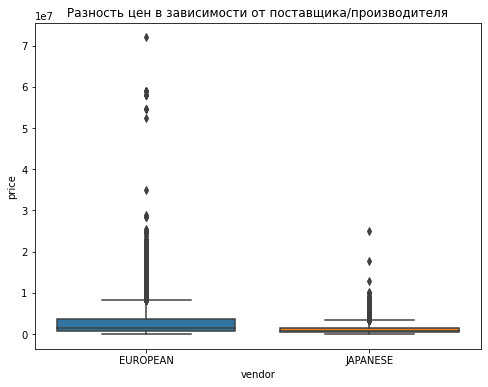

In [43]:
vertical_boxplots('price', 'vendor', df,
                  'Разность цен в зависимости от поставщика/производителя', fsize=[8, 6])

* Тут все просто и логично , Европейский производитель преоблодает

## age-type - категория возраста

Есть закономерность, что как только новый автомобиль пересекает выезд из автосалона сразу теряет 10% в цене. Если посмотреть на график в EDA для года запуска модели или возраста, то можно выделить такие категории:

*    Новое авто 0-1 года
* б/у новое 2-5 лет, как правило уже отражается на износе, страховке и пр.
*    б/у 6-10, авто часто требует вложений
*   более 10 лет



In [44]:
df['car_age'].value_counts()

0     11076
8      5374
12     5062
9      5057
7      4849
      ...  
84        2
46        2
52        1
49        1
63        1
Name: car_age, Length: 70, dtype: int64

In [45]:
# категории авто
df['car_age'] = df.car_age.astype(int)
df.loc[df.car_age.between(0, 1), 'age_type'] = 'new_car'
df.loc[df.car_age.between(2, 5), 'age_type'] = 'used_car'
df.loc[df.car_age.between(6, 10), 'age_type'] = 'midage_car'
df.loc[df.car_age.between(11, 18), 'age_type'] = 'old_car'
df.loc[df.car_age.between(19, 30), 'age_type'] = 'rare_car'
df.loc[df.car_age > 30, 'age_type'] = 'very_rare_car'

In [46]:
df.age_type.value_counts()

midage_car       23069
old_car          19969
new_car          13679
used_car         13247
rare_car          8766
very_rare_car      994
Name: age_type, dtype: int64

* Нечасто, но бывает, что старые авто восстанавливают, такие авто отражены с более малым пробегом и в описании содержатся отличия от базовых моделей и пр. Такие авто вынесем еще в одну категорию - rebuild_car


In [47]:
# медианный пробег для каждого года выпуска и тип восстановленный авто
df.miles = df.miles.astype(int)
med_miles = df.groupby('car_age')['miles'].median().to_dict()
df.loc[(df.miles < 20000) & (df.car_age > 11) & (
    df.bodytype != 'roadster'), 'age_type'] = 'rebuild_car'

In [48]:
def miles_add(row):
    row['miles'] = row['miles'] + med_miles[row['car_age']]
    return row


df.loc[(df.miles < 20000) & (df.car_age > 11) & (df.bodytype != 'roadster')] = df.loc[
    (df.miles < 20000) & (df.car_age > 11) & (df.bodytype != 'roadster')].apply(
    miles_add, axis=1)

## whell - Руль

In [49]:
df.wheel = df.wheel.str.lower()
df.wheel.value_counts()

левый     77019
правый     2705
Name: wheel, dtype: int64

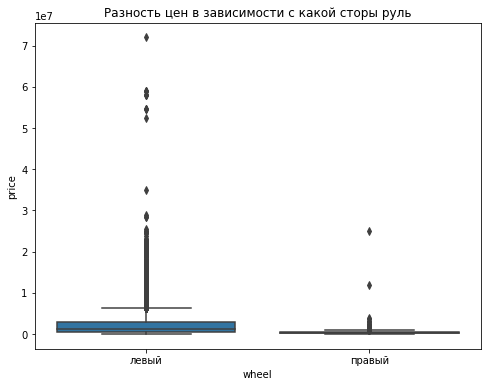

In [50]:
vertical_boxplots('price', 'wheel', df,
                  'Разность цен в зависимости с какой сторы руль', fsize=[8, 6])

* Видно, что автомобили с левым рулем значительно дороже и их больше

## Удаляем не нужные признаки

In [51]:
# Удаляю ненужное
df.drop(['doors', 'section', 'customs', 'url_saleid', 'descr',
         'auto_class', 'equipment_dict', 'image', 'bodytype',
         'options', 'model_info', 'own', 'name', 'car_url',
         'parsing_unixtime', 'pricecurrency', 'veh_conf',
         'rep_state', 'seller_type', 'price_segment', 'super_gen',
         'prod_year'], inplace=True, axis=1)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79724 entries, 0 to 34685
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         79724 non-null  object 
 1   engine_displ  79724 non-null  float64
 2   enginepower   79724 non-null  float64
 3   fuel          79724 non-null  object 
 4   miles         79724 non-null  float64
 5   model_year    79724 non-null  int64  
 6   model_name    79724 non-null  object 
 7   sell_id       79724 non-null  int64  
 8   transm        79724 non-null  object 
 9   vendor        79724 non-null  object 
 10  owners        79724 non-null  int64  
 11  pts           79724 non-null  object 
 12  drive         79724 non-null  object 
 13  wheel         79724 non-null  object 
 14  price         45038 non-null  float64
 15  color         79724 non-null  object 
 16  train         79724 non-null  int64  
 17  body_type     79724 non-null  object 
 18  dealer        79724 non-nu

## Разделяем столбцы

In [53]:
# разделение столбцов по категориям
bin_cols = ['pts', 'discount', ]
cat_cols = ['body_type', 'color', 'drive', 'fuel', 'owners',
            'transm', 'vendor', 'brand', 'wheel',
            'dealer', 'model_name', 'age_type']
num_cols = ['engine_displ', 'miles', 'enginepower', 'car_age',
            'model_year']

## Корреляционный анализ числовых переменных

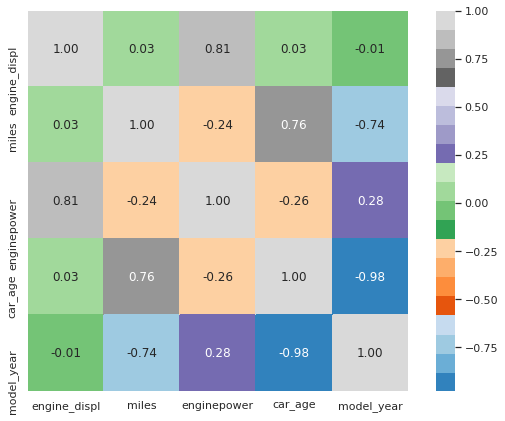

In [54]:
# теперь посмотрим на корреляцию числовых признаков между собой
sns.set(font_scale=1)
plt.subplots(figsize=(10, 7))
sns.heatmap(df[num_cols].corr(), square=True,
            annot=True, fmt=".2f", cmap="tab20c")

* Высокий коэффициент корреляции между признаками возраст авто (car_age) и пробег (miles), объем двигателя(engine_displ), мощность(enginepower)
* Признак объем двигателя  сильно скоррелированным с мощностью . Но при этом не не сет полезной информации, т.к. больше указывает на модель авто, чем на цену.
* Буду оталкиватся от модели

In [55]:
# df.drop(columns = ['engine_displ'], inplace=True)

# Подготовка моделей для ML
* Подготовим финальную предобработку. Разобьем столбцы при помощи get_dummies (one-hot encoding)

In [57]:
df.columns

Index(['brand', 'engine_displ', 'enginepower', 'fuel', 'miles', 'model_year',
       'model_name', 'sell_id', 'transm', 'vendor', 'owners', 'pts', 'drive',
       'wheel', 'price', 'color', 'train', 'body_type', 'dealer', 'discount',
       'car_age', 'age_type'],
      dtype='object')

In [58]:
cols_dum = ['body_type', 'color', 'drive', 'fuel', 'owners',
            'transm', 'vendor', 'brand', 'wheel', 'pts',
            'dealer', 'model_name', 'age_type', 'discount']

df = pd.get_dummies(df, columns=cols_dum, dummy_na=False)

df = df.fillna(0)
df.head(2)

,engine_displ,enginepower,miles,model_year,sell_id,price,train,car_age,body_type_cabriolet,body_type_compact MRV,...,model_name_ZEST,age_type_midage_car,age_type_new_car,age_type_old_car,age_type_rare_car,age_type_rebuild_car,age_type_used_car,age_type_very_rare_car,discount_no,discount_yes
0,1.30,30.00,10939.00,2018,1101362400,2097000.00,1,2,0,0,...,0,0,0,0,0,0,1,0,1,0
1,1.60,24.00,56671.00,2012,1101366591,1298000.00,1,5,0,0,...,0,0,0,0,0,0,1,0,1,0


In [59]:
# Разбиваем наш датафрейм на признаки, целевую переменную и тестовую выборки
test_data = df[df.train == 0].drop(columns=['sell_id', 'price', 'train'])
X = df[df.train == 1].drop(columns=['sell_id', 'price', 'train', ])
y = df[df.train == 1]['price'].values

In [60]:
# Разбиваем на тестовую и тренировочную выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True,
    random_state=RANDOM_SEED)

# CatBoostRegressor

In [62]:
model = CatBoostRegressor(iterations=50,
                          cat_features=X.columns[6:],
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                          )

start = time.time()
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          use_best_model=True,
          verbose=False,
          #          plot=True
          )

# model.save_model('catboost_model.model')


predict = model.predict(X_test)
print_learn_report(start, y_test, predict)


Время выполнения: 51.6

Точность по метрике MAPE: 24.65


### С улучшенными параметрами

In [64]:
model_cbr = CatBoostRegressor(random_seed=RANDOM_SEED,
                              eval_metric='MAPE',
                              custom_metric=['R2', 'MAE']
                              )
start = time.time()
model_cbr.fit(X_train, y_train,
              cat_features=X.columns[6:],
              eval_set=(X_test, y_test),
              verbose_eval=0,
              use_best_model=True,
              )

# model.save_model('catboost_model.model')


predict = model_cbr.predict(X_test)
print_learn_report(start, y_test, predict)


Время выполнения: 55.2

Точность по метрике MAPE: 15.90


# GradientBoostingRegressor

In [65]:
model_gb = GradientBoostingRegressor(min_samples_split=2,
                                     learning_rate=0.03,
                                     max_depth=10,
                                     n_estimators=1000)
start = time.time()
model_gb.fit(X_train, np.log(y_train))


predict = np.exp(model_gb.predict(X_test))
print_learn_report(start, y_test, predict)


Время выполнения: 604.9

Точность по метрике MAPE: 12.44


# RandomForestRegressor

In [66]:
model_rfr = RandomForestRegressor(n_estimators=1000,
                                  max_depth=15,
                                  max_features='log2',
                                  random_state=42,
                                  oob_score=True,)

start = time.time()
model_rfr.fit(X_train, np.log(y_train))


predict = np.exp(model_rfr.predict(X_test))
print_learn_report(start, y_test, predict)


Время выполнения: 52.3

Точность по метрике MAPE: 36.92


# XGBRegressor

In [67]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             colsample_bytree=0.3,
                             learning_rate=0.01,
                             max_depth=25,
                             n_estimators=1000,
                             random_state=42)
model_xgb = xgb.XGBRegressor()
start = time.time()
model_xgb.fit(X_train, y_train)

# predict = np.exp(model_xgb.predict(X_test))
predict = model_xgb.predict(X_test)
print_learn_report(start, y_test, predict)


Время выполнения: 14.8

Точность по метрике MAPE: 16.32


# SUBMISSION

## 1 попытка

In [68]:
# submission_predict = model_xgb.predict(df[df.train == 0].drop(columns=['train', 'price', 'sell_id']))

# sample_submission['price'] = submission_predict

# sample_submission.to_csv('sample_1.csv',index = False)